In [124]:
using IntervalSets, ModelingToolkit
using Sophon
using Optimization, OptimizationOptimJL, OptimizationOptimisers

@parameters t, x
@variables u(..)
Dₜ = Differential(t)
Dₓ = Differential(x)
Dₓ² = Differential(x)^2
Dₓ³ = Differential(x)^3

ν = 0.0025
eqs = [Dₜ(u(t, x)) + Dₓ(u(t, x)) * u(t, x) + ν * Dₓ³(u(t, x)) ~ 0]

bcs = [u(0, x) ~ cospi(x), u(t, -1.0) ~ u(t, 1.0)]

domain = [t ∈ Interval(0.0, 1.0), x ∈ Interval(-1.0, 1.0)]

@named KdV = PDESystem(eqs, bcs, domain, [t, x], [u(t, x)])

PDESystem
Equations: Equation[0.0025Differential(x)(Differential(x)(Differential(x)(u(t, x)))) + Differential(x)(u(t, x))*u(t, x) + Differential(t)(u(t, x)) ~ 0]
Boundary Conditions: Equation[u(0, x) ~ cospi(x), u(t, -1.0) ~ u(t, 1.0)]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(t, 0.0..1.0), Symbolics.VarDomainPairing(x, -1.0..1.0)]
Dependent Variables: Num[u(t, x)]
Independent Variables: Num[t, x]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

In [134]:
chain = Siren(2, 1; hidden_dims=16, num_layers=5, omega=1f0)
pinn = PINN(chain)
sampler = BetaRandomSampler(1000, 300)
strategy = NonAdaptiveTraining(1, (50, 20))
prob = Sophon.discretize(KdV, pinn, sampler, strategy)

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(layer_1 = (weight = [0.19887804985046387 -0.16646134853363037; -0.4533827304840088 0.22434550523757935; … ; -0.44418013095855713 0.04633986949920654; 0.0008277297019958496 -0.09084069728851318], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [0.5780853033065796 0.4048370122909546 … -0.45757627487182617 -0.4818708300590515; -0.3334704339504242 0.31305569410324097 … 0.2781500816345215 -0.1251041293144226; … ; -0.2831491529941559 -0.09386584162712097 … -0.5085377097129822 0.33310234546661377; -0.2690160274505615 0.545676589012146 … 0.27543553709983826 0.605154812335968], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = [0.2865327298641205 -0.040068209171295166 … -0.26783138513565063 -0.06383066624403; 0.12276460975408554 0.4618473947048187 … -0.019694799557328224 -0.3668980598449707; … ; 0.492542564868927 0.1707153469324112 … 0.14160464704036713 -0.012688870541751385; 0.20209963619709015 0.4122493267059326 … 

In [135]:
i = 0
function callback(p, l)
    global i
    i%100==0 && println("Loss: $l")
    i += 1
    return false
end

res = Optimization.solve(prob, BFGS(); maxiters=1000, callback=callback)

Loss: 29.081009846774585


Loss: 0.17728414805823148


Loss: 0.02739088356656712


Loss: 0.0038185602004921367


Loss: 0.0018318742465682687


Loss: 0.0012402559274372704


Loss: 0.0008378424143400269


Loss: 0.0005868243159787452


Loss: 0.00043521549753833727


Loss: 0.0002873588566736223


Loss: 0.0001935092785399787


u: ComponentVector{Float64}(layer_1 = (weight = [0.21954393945726777 -0.9290528143253063; -0.4229676932441472 0.176895585216769; … ; -0.6790172123308144 -0.14852055958505808; 0.31414883695926704 -0.4069527371473996], bias = [0.30121712929391753; 0.04626981095536488; … ; -0.13261945111461695; -0.0842177558252889;;]), layer_2 = (weight = [0.6778932598190393 0.18243560265623518 … -0.5083609860273282 -0.35595256457413166; 0.15183509749864388 0.5303041922776998 … 0.3072948635866245 -0.3365832458164681; … ; -0.20578583755401386 0.11695326628858006 … -0.49930466189066 -0.12378157584198722; -0.5859229799378913 0.34443886427620835 … 0.2194621948668613 0.6732216782431376], bias = [0.46984222403669745; -0.19282447881802936; … ; -0.4143562547945644; 0.31870296137818416;;]), layer_3 = (weight = [0.269405175958393 -0.4570081558994637 … 0.38942787933731127 0.13396764149841583; -0.1457484114697003 0.7799358157793767 … 1.3938848551977643 -0.3853824808438621; … ; 0.44423380005492713 -0.00754202731170095

In [127]:
using MAT
data = matread("KdV.mat")

usol = data["uu"]

# Grid
t_star = vec(data["tt"])
x_star = vec(data["x"]);

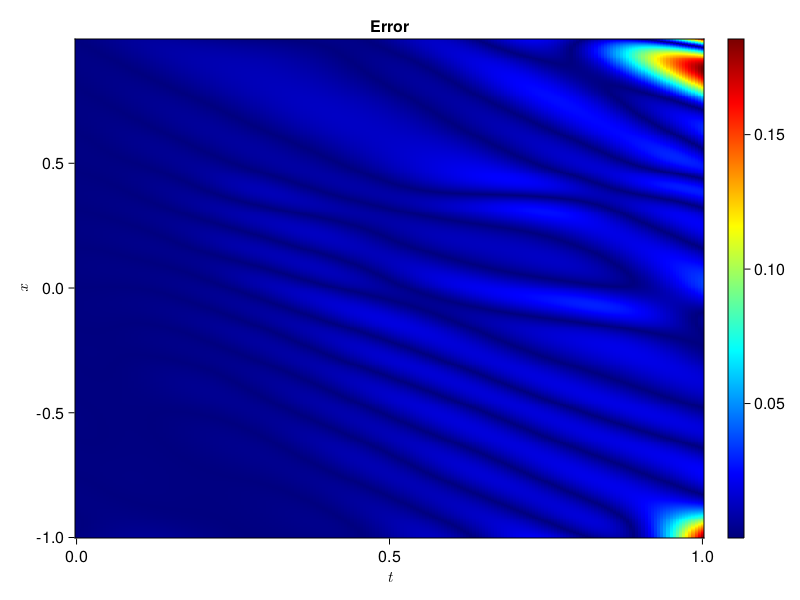

In [136]:
using CairoMakie, MakiePublication

phi = pinn.phi
u_pred = [sum(pinn.phi([t, x], res.u)) for t in t_star, x in x_star]
fig, ax, hm = heatmap(t_star, x_star, abs.(u_pred .- usol');
                      axis=(xlabel=L"t", ylabel=L"x", title="Error"), colormap=:jet)
Colorbar(fig[:, end + 1], hm)
fig

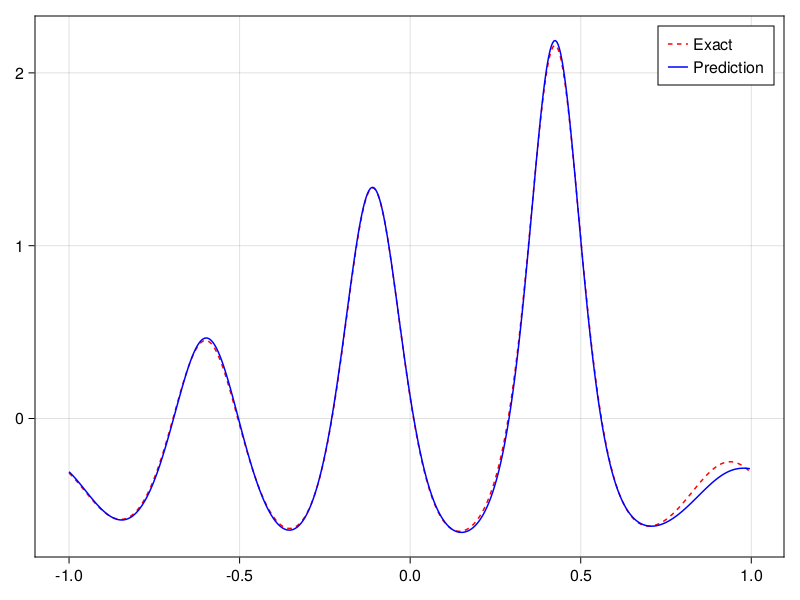

In [129]:
fig = Figure()
axis = Axis(fig[1, 1])
lines!(x_star, usol[:, end], label="Exact", color=:red,  linestyle = :dash)
lines!(x_star, u_pred[end, :], label="Prediction", color=:blue)
axislegend(axis)
fig

Loss: 0.0006515927226586101


Loss: 0.0001337649195141966


Loss: 7.744323769702166e-5


Loss: 4.940221495686901e-5


Loss: 3.6155269677464986e-5


Loss: 2.9006797399952498e-5


Loss: 2.2973186967644232e-5


Loss: 1.8698945525623905e-5


Loss: 1.4935037263172638e-5


Loss: 1.2982928659986408e-5


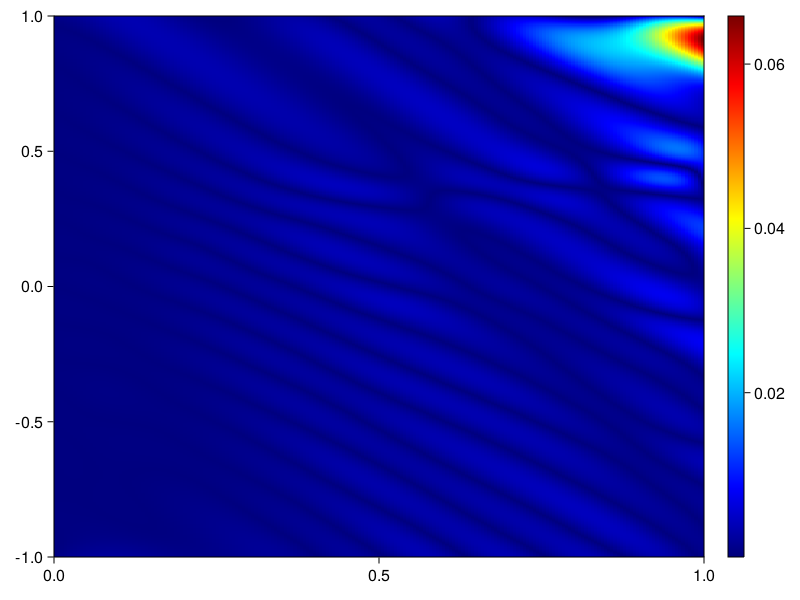

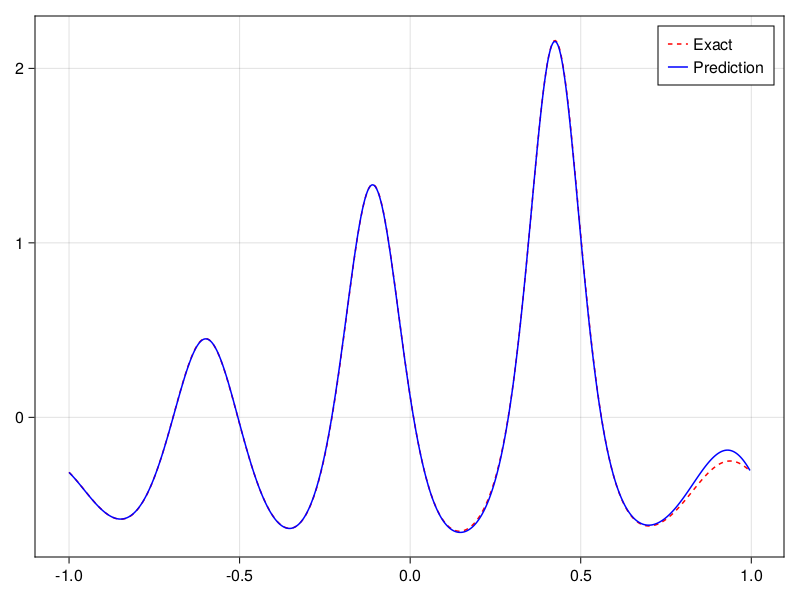

Loss: 1.1158287120955193e-5


Loss: 0.0007593987352886162


Loss: 3.619976478851405e-5


Loss: 1.9961082880858376e-5


Loss: 1.492576056408797e-5


Loss: 1.2077411090857793e-5


Loss: 1.0074439371324192e-5


Loss: 8.437513179289886e-6


Loss: 6.901412634307793e-6


Loss: 5.935989219766848e-6


Loss: 4.909449613951248e-6


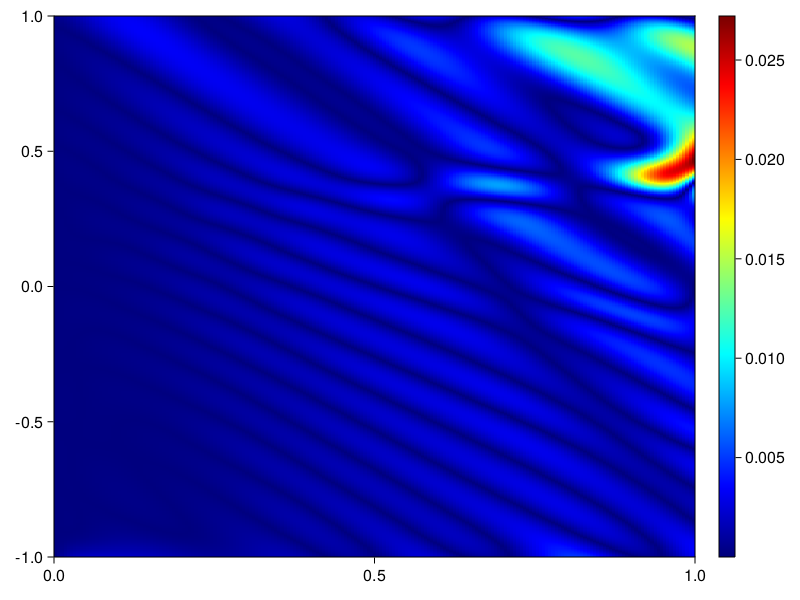

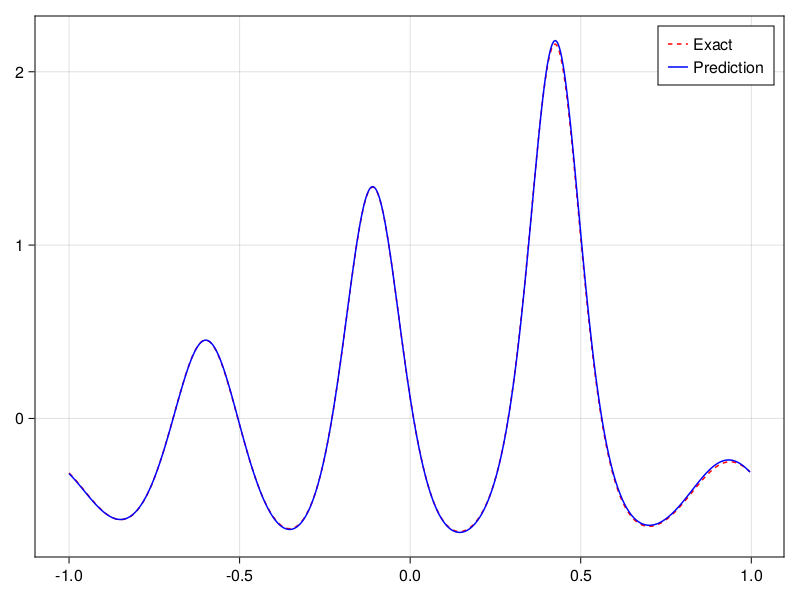

Loss: 4.146883764132689e-6


Loss: 0.00032666902906497517


Loss: 1.9276738976695486e-5


Loss: 9.813938457327481e-6


Loss: 6.821533262192841e-6


Loss: 5.373546356139907e-6


Loss: 4.696010585559458e-6


Loss: 4.161772035436952e-6


Loss: 3.7957869553413474e-6


Loss: 3.439191220972778e-6


Loss: 3.0882273275262324e-6


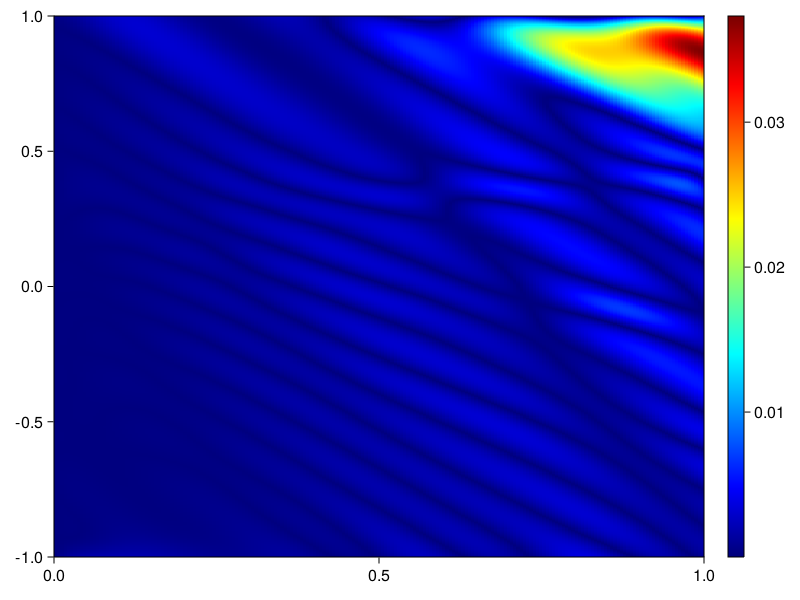

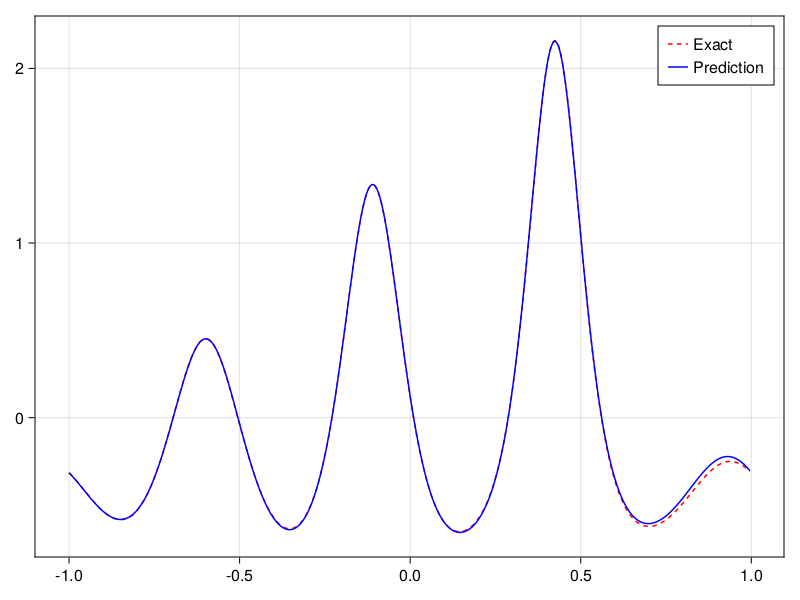

Loss: 2.8581740393230054e-6


In [130]:
for α in [0.6, 0.8, 1.0] 
    i=0
    sampler = remake(sampler; α=α)
    data = Sophon.sample(KdV, sampler)
    prob = remake(prob; p=data, u0=res.u)
    res = Optimization.solve(prob, BFGS(); maxiters=1000, callback=callback)

    u_pred = [sum(pinn.phi([t, x], res.u)) for t in t_star, x in x_star]
    fig, ax, hm = heatmap(ts, xs, abs.(usol' .- u_pred), colormap=:jet)
    Colorbar(fig[:, end + 1], hm)
    display(fig)

    fig = Figure()
    axis = Axis(fig[1, 1])
    lines!(x_star, usol[:, end], label="Exact", color=:red,  linestyle = :dash)
    lines!(x_star, u_pred[end, :], label="Prediction", color=:blue)
    axislegend(axis)
    display(fig)
end


In [138]:
res.objective

2.680259929428943e-5

In [139]:
using JLD2
jldsave("KdV.jld2"; pde=KdV, pinn=pinn, res=res, prob=prob)